# Generando un tren de pulsos de radar pulsado

Un radar pulsado es aquel capaz de medir tanto rango (distancia) como velocidad, haciendo uso de la transmisión de un pulso y leyendo el reflejo del mismo en alguna superficie. El pulso reflejado tardara un determinado delta de tiempo (diferencia entre que se transmite y se recibe) el cual hace valer la siguiente expresión:   
 ### <center> $R = \frac{\Delta t*c}{2}$            
  Donde $R$ es el rango y $c$ es la velocidad de propagación de la onda, que al ser electromagnética corresponde a la velocidad de la luz. Con esta información y midiendo el $\Delta t$, podemos calcular una estimación del rango.

In [32]:
import adi
import numpy as np
from commpy.filters import rrcosfilter
from sk_dsp_comm import digitalcom as dc
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fftpack import fftfreq

In [33]:
#------------------------------- SDR Parameter Configuration -------------------------------

Uri              = "ip:192.168.1.34" 
SamplingRate     = 4e6           # Sample rate RX and TX paths[Samples/Sec]
Loopback         = 1           # 0=Disabled, 1=Digital, 2=RF

TxLOFreq         = 918e6         # Carrier frequency of TX path [Hz] RELLENAR CON LA FREC. DE PORTADORA ASIGNADA
TxAtten          = -30           # Attenuation applied to TX path, valid range is -90 to 0 dB [dB]
TxRfBw           = 4e6           # Bandwidth of front-end analog filter of TX path [Hz]

RxLOFreq         = TxLOFreq      # Carrier frequency of RX path [Hz]
GainControlModes = "slow_attack" # Receive path AGC Options: slow_attack, fast_attack, manual
RxHardwareGain   = 0             # Gain applied to RX path. Only applicable when gain_control_mode is set to 'manual'    
RxRfBw           = TxRfBw        # Bandwidth of front-end analog filter of RX path [Hz] 
RxBufferSize     = 2**20-1

Definimos variables como el PRI (pulse repetition interval) y su inversa, PRF (pulse repetition frequency). Por otro lado, determinamos la frecuencia de sampling y de transmisión dentro del pulso. El valor del PRI nos dará el rango máximo calculable por nuestro radar, ya que, nuestro pulso debe ser transmitido y recibido antes de volver a transmitir el segundo pulso. Es por esto que la máxima distancia calculable es:   
### <center> $Max Range = \frac{c}{2} * PRI $.

En nuestro caso, la distancia máxima es de 150000 [m] o 150 [km] para un PRI de 0.001 [s] y una PRF de 1[kHz].

In [34]:
PRI = 0.001 #[s] 
PRF = 1/PRI
potencia_señal = 1

beta = 0.3
sps = 8 
span = 6

sample_f = SamplingRate
step = 1/SamplingRate
f1 = 500e3
samples = int(100* sample_f/f1)
samples = 50*int(PRI/step)

En las siguientes celdas generamos nuestra señal a transmitir ,nuestro vector de tiempo y se realiza la configuración de la SDR haciendo uso de la libreria adi.

\begin{equation}
    Tx_I = \sin(2* \pi * f_1 * t)
\end{equation}

\begin{equation}
    Tx_Q = \sin(2* \pi * f_1 * t)
\end{equation}

In [35]:
t = np.linspace(0,(samples-1)*step,samples)
pulse_length = 0.00005 #[s] => 0.5 ms
Tx_I = 10*np.sin(2*np.pi*f1*t) + 10
#Tx_Q = np.sin(2*np.pi*f1*t + np.pi/2)
zeros = np.zeros(len(t))
ones = np.ones(int(pulse_length/step))

for i in range(0,len(Tx_I),int(PRI/step)):
      zeros[i:i+len(ones)] = ones

In [36]:
Tx_I = Tx_I * zeros # parte real de la señal
Tx_Q = Tx_Q * zeros #parte imaginaria
Tx = Tx_I + 1j * Tx_Q

In [136]:
#-----------------------------------SDR Configurations-------------------------------
sdr             = adi.Pluto(Uri)
sdr.sample_rate = SamplingRate
sdr.loopback    = Loopback
#Tx:
sdr.tx_lo                 = int(TxLOFreq)
sdr.tx_hardwaregain_chan0 = TxAtten 
sdr.tx_rf_bandwidth       = int(TxRfBw)
sdr.tx_buffer_size        = samples
sdr.tx_cyclic_buffer      = True
# Rx:
sdr.rx_lo                   = int(RxLOFreq)
sdr.gain_control_mode_chan0 = GainControlModes
sdr.rx_rf_bandwidth         = int(RxRfBw)
sdr.rx_cyclic_buffer        = False
sdr.rx_buffer_size          = RxBufferSize
sdr.rx_enabled_channels = [0]

Exception: No device found

# Transmisión y Recepción

In [ ]:
#------------------------------- Transmitter ------------------------------- 

sdr.tx(Tx_I*2**14)

In [7]:
#------------------------------- Receiver ------------------------------- 
rxSignal = sdr.rx()/2**14

rows, cols = (10, int(PRI/step))
recieved_signal = [[0 for i in range(cols)] for j in range(rows)] 
for i in range(rows):
    recieved_signal[i] = rxSignal[i*int(PRI/step):i*int(PRI/step)+int(PRI/step)]

NameError: name 'sdr' is not defined

Luego de transmitir la señal, utilizamos la antena receptora para hacer la lectura correspondiente del pulso reflejado. En este caso tomamos de a 10 muestras de la señal reflejada guardadas en una matriz con 10 filas y n columnas, siendo n igual a la cantidad de muestras que hay en un determinado pulso (equivalente al tiempo PRI).

### Simulación 

Se trata de recrear la situación de recepción de acuerdo a la distancia a la que estaria un determinado objeto con su correspondiente retarto, ruido y atenuación

In [44]:
#Reflected pulse
distance = 5000 #[m]
returned_pulse = (1/distance**2)*Tx_I[:int(pulse_length/step)+1] #Se guarda un pulso de los transmitidos con su atenuación
ret_pulse = np.ones(len(returned_pulse))
for i in range(len(returned_pulse)):
    ret_pulse[i] = returned_pulse[len(returned_pulse)-1-i] #Se guarda el pulso reflejado

delta_t = (distance*2/299792458) #Calculo del delta t correspondiente
print(delta_t)
Rx_I = np.zeros(50*int(PRI/step)+1) #10 pulsos recibidos
sample_shift = int(delta_t/step) #Cuantas muestras se debe shiftear el pulso recibido de acuerdo a la distancia que representa

for i in range(50):
    Rx_I[i*int(PRI/step)+sample_shift:i*int(PRI/step)+sample_shift+int(pulse_length/step)+1] = ret_pulse #Señal shifteada

snr_dB = 8  # SNR en decibelios
snr_linear = 10 ** (snr_dB / 10.0)  # Convertir SNR a escala lineal

# Generar ruido gaussiano
potencia_ruido = np.var(Tx_I) / snr_linear
ruido = np.random.normal(0, np.sqrt(potencia_ruido), len(t)+1)
    
Rx_I = Rx_I + ruido #Se le agrega ruido

3.3356409519815205e-05


### Transformada Rápida de Fourier (FFT)

In [45]:
#FFT
f_f_salida = np.abs(np.fft.fft(Tx_I))/samples
f_plot = 2 * f_f_salida[0:int(samples/2+1)]
f_plot[0] = f_plot[0]/2
f_step = sample_f/samples
frec = np.linspace(0,(samples-1)*f_step,samples)
frec_plot = frec[0:int(samples/2+1)]

### Matched Filter
Hacemos uso de un matched filter con respuesta al impulso igual al pulso transmitido y hacemos convolucionar la señal recibida con el mismo. Esto para mejorar la relación señal ruido (SNR), ya que es mucho mayor la correlación entre el pulso y las partes de la señal recibida equivalentes al pulso reflejado que al ruido, amplificando mucho mas la señal y haciendo más fácil su lectura. Además, sabemos que la señal recibida presenta una gran atenuación frente a la transmitida debido a la pérdida de energía en el traslado de la misma o de la distancia al objeto reflector.

In [46]:
#Matched filter used to maximize SNR ratio
def matched_filter(pulse,signal):
    #debo conjugar la señal o utilizar el pulso conjugado
    return np.convolve(np.conjugate(pulse),signal)
rows, cols = (50, int(PRI/step))
con =  [[0 for i in range(cols)] for j in range(rows)]
for i in range(rows):
       con[i] = matched_filter(Tx_I[0:int(PRI/step)+1],Rx_I[i*int(PRI/step):i*int(PRI/step)+int(PRI/step)])


### Cálculo y estimación del rango
Haciendo uso de las 10 muestras tomadas, y de hacer pasar la señal recibida por el matched filter, es tiempo de calcular los distintos $\Delta t$ para cada muestra. Luego de hacer esto se calcula la media y se determina el valor estimado por el radar.

In [47]:
#Delta time detector
#max = rxSignal[0]
index_max_j = 0
max_con = []            
for i in range(rows):
    max_i = 0
    for j in range(len(con[i])):
        if(con[i][j]>max_i):
            max_i = con[i][j]
            index_max_j = j - int(pulse_length/step)
    max_con.append(t[index_max_j])

stimation_delta_t = sum(max_con)/len(max_con)
print("Stimated delta time: " + str(stimation_delta_t) + "[s]")
stimation_range = stimation_delta_t*299792458/2
print("Stimated range: " + str(stimation_range) + "[m]")

Stimated delta time: 0.0014306850000000001[s]
Stimated range: 214454.28638686502[m]


### Gráfico: varianza en la estimación del rango vs SNR 

### Gráficos de la señal

0.411319775
2.0
0.41860049999999993
2.5
0.44684468125000004
3.0
0.2796849749999999
3.5
0.6136980062500001
4.0
0.6211970249999998
4.5
0.9871281812499999
5.0
1.0773685062499998
5.5
1.0020947562499998
6.0
0.8114341812499997
6.5
0.46709022499999986
7.0
0.86764243125
7.5
0.7063465562499999
8.0
0.4442803499999999
8.5
0.61344285
9.0
0.54062775
9.5
0.6739818750000001
10.0
0.8456646312499999
10.5
0.6073743999999998
11.0
0.7042944749999999
11.5
0.8434917499999999
12.0
0.8873501499999998
12.5
0.80057075625
13.0
0.91077238125
13.5
1.3832225062499999
14.0
2194.7671321000007
14.5
2224.86710463125
15.0
1.0045430062499998
15.5
0.7028375062499996
16.0
1.0187930562499998
16.5
0.8932932499999999
17.0
1.04172713125
17.5
0.3709201
18.0
1.15003075
18.5
0.628329525
19.0
0.73713830625
19.5
0.23829330624999995
20.0
0.10997197499999997
20.5
0.747457225
21.0
0.5586530000000002
21.5
1.0068105249999997
22.0
2240.0173187812497
22.5
0.06861784999999997
23.0
0.016280556250000005
23.5
0.004117875
24.0
0.01912550624999

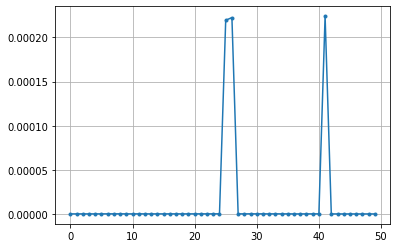

In [85]:
delta_time_stimations = []
var = []
snr = []
samples_p = [[0 for i in range(cols)] for j in range(10)]

Rx_I_aux = np.zeros(10*int(PRI/step)+1) #10 pulsos recibidos
sample_shift = int(delta_t/step) #Cuantas muestras se debe shiftear el pulso recibido de acuerdo a la distancia que representa

for i in range(10):
    Rx_I_aux[i*int(PRI/step)+sample_shift:i*int(PRI/step)+sample_shift+int(pulse_length/step)+1] = ret_pulse #Señal shifteada

np.random.seed(123)

for i in range(50): #number of runs to make graph
    delta_time_stimations = []  #Delta time stimations for a noise with var of i*10**-7
    
    
    for j in range(10):  #number of samples per run
        snr_dB = 2 + i*(0.5)  # SNR en decibelios
        snr_linear = 10 ** (snr_dB / 10.0)  # Convertir SNR a escala lineal

        # Generar ruido gaussiano
        potencia_ruido = np.var(Tx_I) / snr_linear
        ruido = np.random.normal(0, np.sqrt(potencia_ruido), len(t)+1)
        
        samples_p[j] = (Rx_I_aux[:int(PRI/step)]*10**5)  + ruido[:int(PRI/step)] 
        #samples_p[j] = (Rx_I_aux[:int(PRI/step)]*10**5)  + np.random.normal(0,(10**-2+(1+i)*10**-4.6),len(Rx_I[:int(PRI/step)]))
    
    con2 =  [[0 for i in range(cols)] for j in range(rows)] #matrix with convolutioned signals
    
    for j in range(10): #passing through the matched filter
        con2[j] = matched_filter(Tx_I[0:int(pulse_length/step)+1],samples_p[j])
    
    max_i = con2[0][0]
    index_max_j_p = 0
    max_con_p = []            
    
    for z in range(10): #loops through every delta time stimation in each run
        max_i = 0 
        for j in range(len(con2[z])):
            if(con2[z][j]>max_i):
                max_i = con2[z][j]
                index_max_j_p = j - int(pulse_length/step)
        delta_time_stimations.append(t[index_max_j_p])
        max_con_p.append(t[index_max_j_p])
    print(np.std(delta_time_stimations)**2 * 10000000)    
    print(snr_dB)
    snr.append(snr_dB)
    var.append(np.std(delta_time_stimations)**2)
    #print(np.std(delta_time_stimations)**2)

plt.plot(var,'.-')
#plt.plot(con2[0])
#plt.plot(samples_p[0])
plt.grid()

200000


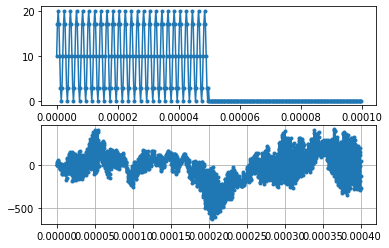

In [42]:
#plot signal
fig, [ax1,ax2] = plt.subplots(nrows =2, ncols = 1)
ax1.plot(t[000:400],Tx_I[000:400],'.-')
ax2.plot(t[00:1600],con[5][00:1600],'.-')
#ax2.plot(t[00:10000],Tx_Q[00:10000],'.-')
#x2.plot(t[:1000],rxSignal[:1000],'.-')
#ax3.plot(frec_plot[0:6000],f_plot[0:6000],'.-')
print(samples)
plt.grid()
plt.show()

In [100]:
# Since it is not possible to turn off Tx, it is configured to transmit at low power and on a different frequency than Rx.
sdr.tx_destroy_buffer()
TxAtten  = -70
RxLOFreq = 2400e6
sdr.tx(np.zeros(1024))

NameError: name 'sdr' is not defined

In [53]:
# Destroy radio object
del(sdr)